In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os, os.path
CAFFE_ROOT_DIR = '/mnt/ilcompf0d0/user/xliu/code/caffe/'
sys.path.append(os.path.join(CAFFE_ROOT_DIR, 'python'))
import caffe
from caffe.io import caffe_pb2
import py_data_layers
import numpy as np

from numpy import linalg as LA

In [2]:
def get_net(network_fn, model_fn, mode='CPU'):
    if mode == 'CPU':
        caffe.set_mode_cpu()
    else:
        caffe.set_mode_gpu()
    net = caffe.Net(network_fn, model_fn,
                    caffe.TEST)
    return net

def vis_square(data, figure_fn=None, padsize=1, padval=0, color_map='gray'):
    data -= data.min()
    data /= data.max()
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])

    imgplot = plt.imshow(data)
    # set colormap, only for single channel images
    if data.ndim == 2:
        imgplot.set_cmap(color_map)
    if figure_fn is None:
        plt.show()
    else:
        plt.savefig(figure_fn)

def visualize_network_filter(network_fn, model_fn, base_dir='./', figure_fn=None, layer='conv1'):
    os.chdir(base_dir)
    print 'Chaning to dir = {}'.format(base_dir)
    net = get_net(network_fn, model_fn)
    plt.clf()
    if layer not in net.params.keys():
        print "Wrong Layer Name: {}".format(layer)
        return
    filters = net.params[layer][0].data
    #vis_square(filters.transpose(0,2,3,1), figure_fn)
    if filters.shape[1] == 3:
        vis_square(filters.transpose(0,2,3,1), figure_fn)
    else:
        filters = filters[:, 0:3, :, :]
        # filters = filters.reshape((filters.shape[0] * filters.shape[1], 1, filters.shape[2], filters.shape[3]))
        vis_square(filters.transpose(0,2,3,1), figure_fn)

In [3]:
def transform_img(img):
    img = img.transpose(1,2,0)
    img = img[:,:,::-1]
    return img

def add_mean(img, image_mean):
    if image_mean.ndim == 1:
        image_mean = image_mean[:, np.newaxis, np.newaxis]
    img += image_mean
    return img

In [4]:
solver_dir = os.path.join(CAFFE_ROOT_DIR, 'examples/distilling/triplet_projects')
os.chdir(solver_dir)
caffe.set_mode_gpu()
caffe.set_device(2)

In [5]:
network_fn = 'train_val_conv.prototxt'
solver_fn = 'solver_conv.prototxt'

Modifying Network Parameter

In [6]:
network_param = caffe.io.read_net_param(network_fn)
loss_layer = network_param.layer[-1]
print loss_layer

name: "loss"
type: "TripletLoss"
bottom: "feat_norm"
bottom: "feat_norm_p"
bottom: "feat_norm_n"
top: "loss"
triplet_loss_param {
  margin: 0.10000000149
}



In [7]:
loss_layer.triplet_loss_param.margin = 0.2
print loss_layer

name: "loss"
type: "TripletLoss"
bottom: "feat_norm"
bottom: "feat_norm_p"
bottom: "feat_norm_n"
top: "loss"
triplet_loss_param {
  margin: 0.2
}



**Using str(network_param) instead of SerialToString() method**

Otherwise, C++ will get errors in parsing from ```char*``` to protobuf message

In [13]:
net = caffe.Net(str(network_param), caffe.TEST)

Using PrefetchSiameseLayer
Setting up python data layer: [type = TripletDataLayer]
Preloading data from LMDB...
[TripletDataLayer]: Preloading image data done [1.80731797218 second]
Total number of samples pre-loaded: 54592


In [14]:
solver = caffe.SGDSolver(solver_fn)

Using PrefetchSiameseLayer
Setting up python data layer: [type = TripletDataLayer]
Preloading data from LMDB...
[TripletDataLayer]: Preloading image data done [39.3281209469 second]
Total number of samples pre-loaded: 1370918
Using PrefetchSiameseLayer
Setting up python data layer: [type = TripletDataLayer]
Preloading data from LMDB...
[TripletDataLayer]: Preloading image data done [1.24815511703 second]
Total number of samples pre-loaded: 54592


In [16]:
solver.net.layers[-1]

### Visualize Trained Models

In [71]:
network_fn = 'train_val_conv.prototxt'
# model_fn = 'triplet_project_iter_28000.caffemodel'
model_fn = 'triplet_project_lr_0.02_iter_30000.caffemodel'

Chaning to dir = ./
Using PrefetchSiameseLayer
Setting up python data layer: [type = TripletDataLayer]
Preloading data from LMDB...
[TripletDataLayer]: Preloading image data done [4.75723290443 second]
Total number of samples pre-loaded: 54592


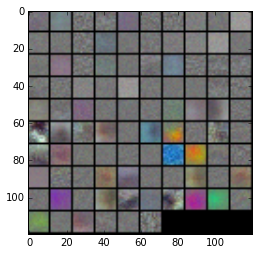

In [72]:
visualize_network_filter(network_fn, model_fn)